# Import Packages

In [423]:
"""
Main File for QRT - Electricity Price - 2023 Project
"""
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

from scipy.stats import spearmanr

from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import make_scorer

# Useful Functions

In [413]:
def plot_ts(ts_x: pd.Series, ts_y: pd.Series, title: str = None, figsize=(13, 5)) -> None:
    """plots a given timeseries and displays an optional title"""
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    plt.plot(ts_x, ts_y)
    plt.title(title or '', fontsize=10)
    plt.grid(alpha=0.5, linestyle='dashed')
    plt.show()


def metric_train(output, Y_clean):
    return 100 * (spearmanr(output, Y_clean).correlation)

# Data Preprocessing

In [414]:
# Importing Data From Files
curr_dir = '/Users/talhajamal/Desktop/Code/Python_Projects/QRT - 2023 - Electricity Price/'
os.chdir(curr_dir)

X = pd.read_csv(f"{curr_dir}data/X_train_NHkHMNU.csv").set_index('ID').sort_values(by='DAY_ID')
X = X.fillna(method='ffill')  # Forward Fill Missing Data
X = X.fillna(method='bfill')  # Backward Fill introduces lookahead bias
X = pd.get_dummies(X, columns=['COUNTRY'])  # One Hot Encoding for each country

y = pd.read_csv(f"{curr_dir}data/y_train_ZAN5mwg.csv").set_index('ID')
#y = pd.merge(X[['ID']], y, on='ID')  # Align the ID column of X and y
y = X.join(y)[['TARGET']] # Align the ID column of X and y


x_validation = pd.read_csv(f"{curr_dir}data/X_test_final.csv").set_index('ID')
x_validation = x_validation.fillna(method='ffill') # Forward Fill the Missing Data
x_validation = x_validation.fillna(method='bfill') # Backward Fill introduces lookahead bias
x_validation = pd.get_dummies(x_validation, columns=['COUNTRY']) # One Hot Encoding for each country

In [415]:
X.head()

,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,...,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_DE,COUNTRY_FR
ID,,,,,,,,,,,,,,,,,,,,,
1057,0,0.048418,-0.465067,-0.079296,0.079296,0.405549,0.650577,-0.405549,-0.650577,0.592572,...,-0.856204,-0.655528,-1.099226,0.279885,0.583874,-1.071996,-0.074767,0.798003,False,True
1179,1,0.966997,1.222131,0.331356,-0.331356,0.405549,0.778627,-0.405549,-0.778627,1.111008,...,-0.497520,-1.184018,-1.465608,1.349212,0.231602,1.480313,0.931562,0.822047,False,True
1327,2,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,-0.256736,1.228079,...,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,False,True
111,2,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,-0.256736,1.228079,...,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,True,False
2016,3,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,0.612133,1.588542,...,-1.118297,0.244859,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756,False,True


In [416]:
y.head()

,TARGET
ID,
1057,0.108953
1179,-0.063369
1327,2.575976
111,0.861270
2016,0.068905


In [417]:
x_validation.head()

,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,...,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_DE,COUNTRY_FR
ID,,,,,,,,,,,,,,,,,,,,,
1115,241,0.340083,-0.433604,-0.423521,0.423521,0.165333,0.519419,-0.165333,-0.519419,1.524963,...,-0.182048,-0.982546,-0.876632,0.880491,0.692242,0.569419,-0.029697,-0.929256,False,True
1202,1214,0.803209,0.780411,0.601610,-0.601610,0.342802,0.555367,-0.342802,-0.555367,1.064102,...,-0.301094,-0.759816,-1.221443,-0.616617,-0.737496,0.251251,0.753646,0.664086,False,True
1194,1047,0.795540,0.721954,1.179158,-1.179158,1.620928,0.666901,-1.620928,-0.666901,0.128004,...,-0.367248,0.376055,-0.483363,0.865138,0.120079,-1.485642,-0.326450,-0.349747,False,True
1084,1139,0.172555,-0.723427,-0.044539,0.044539,1.620928,-0.205276,-1.620928,0.205276,1.046069,...,-0.013291,-0.791119,-0.894309,0.239153,0.457457,-0.746863,2.262654,0.642069,False,True
1135,842,0.949714,0.420236,0.617391,-0.617391,0.608561,-0.240856,-0.608561,0.240856,1.376753,...,-0.609203,-0.744986,-1.196282,0.176557,0.312557,-2.219626,-0.509272,-0.488341,False,True


# Missing Data

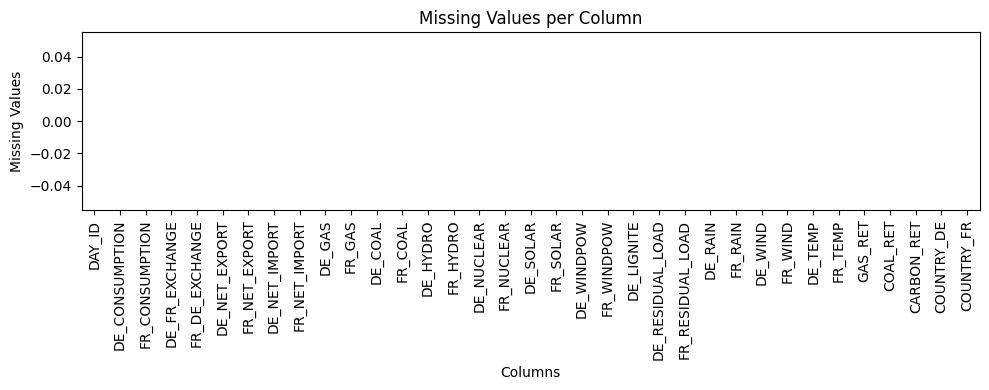

In [418]:
missing_values = X.isna().sum()
missing_values.plot(kind='bar', figsize=(10, 4), color='skyblue')
plt.title('Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Missing Values')
plt.xticks(rotation=90)  # Rotate the x labels to show them vertically
plt.tight_layout()  # Adjust layout to make room for the x labels
plt.show()

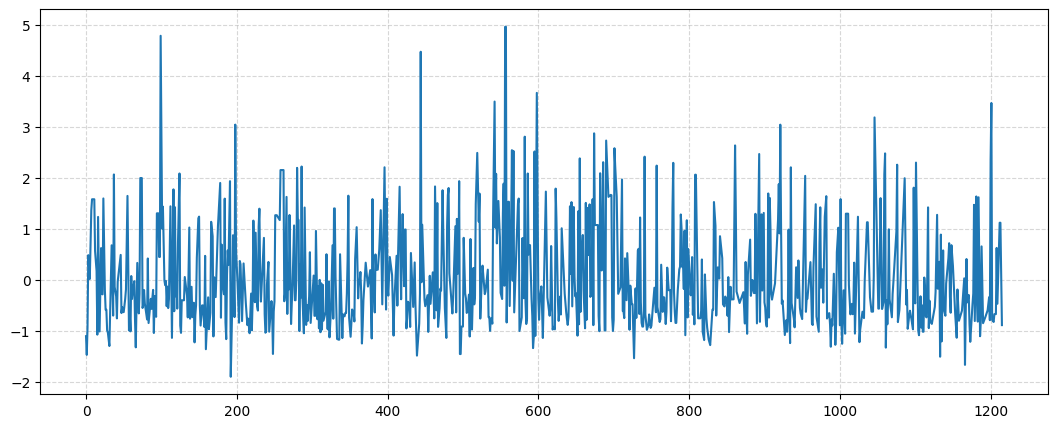

In [419]:
plot_ts(X['DAY_ID'], X['FR_WIND'])

# Fill Data

In [396]:
# Combined Training and Testing Data
# full_data = pd.concat([x_train, x_test], axis=0).sort_index()
# de_full_data = full_data[full_data['COUNTRY'] == 'DE']
# fr_full_data = full_data[full_data['COUNTRY'] == 'FR']

# x_train = x_train.interpolate(method='linear')
# x_test = x_test.interpolate(method='linear')

# Separating data for each country
# de_x_train = x_train[x_train['COUNTRY'] == 'DE']
# de_y_train = y_train[y_train.index.isin(de_x_train.index)]
# fr_x_train = x_train[x_train['COUNTRY'] == 'FR']
# fr_y_train = y_train[y_train.index.isin(fr_x_train.index)]

# XGBoost Regression

In [420]:
X_clean = X
Y_clean = y['TARGET']

# Create a scorer from the custom metric function
spearman_scorer = make_scorer(metric_train, greater_is_better=True)

# Define your parameter grid
param_grid = {
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'max_depth': [10, 12, 15],
    'alpha': [5, 10, 15],
    'n_estimators': [50, 100, 200]
}

# Initialize your model
xgb_reg = XGBRegressor(objective='reg:squarederror')

# Setup GridSearchCV or RandomizedSearchCV with your custom scorer
cv_method = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=5,
                         scoring=spearman_scorer, verbose=2, n_jobs=-1)

# Assuming X_clean and Y_clean are already defined and preprocessed
X_train, X_test, y_train, y_test = train_test_split(X_clean, Y_clean, test_size=0.20, random_state=42)

# Fit the model to find the best parameters
cv_method.fit(X_train, y_train)

# Best parameters found
print("Best parameters found: ", cv_method.best_params_)

# Predict on the test set with the best parameters
y_pred = cv_method.predict(X_test)

# Calculate Spearman correlation on the test set
test_spearman_correlation = metric_train(y_test, y_pred) 
print('Test set Spearman correlation: {:.1f}%'.format(test_spearman_correlation))

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV] END alpha=5, colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END alpha=5, colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END alpha=5, colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END alpha=5, colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.1s
[CV] END alpha=5, colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.1s
[CV] END alpha=5, colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END alpha=5, colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END alpha=5, colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END alpha=5, colsample_bytree=0.3, learning_rate=0.01, m

In [428]:
# Assuming X_clean and Y_clean are already defined and preprocessed
X_train, X_test, y_train, y_test = train_test_split(X_clean, Y_clean, test_size=0.20, random_state=42)

# Define your parameter grid
param_grid = {
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'max_depth': [10, 12, 15],
    'alpha': [5, 10, 15],
    'n_estimators': [50, 100, 200]
}

# Initialize your model
xgb_reg = XGBRegressor(objective='reg:squarederror')

# Setup GridSearchCV with the scoring function focused on minimizing MSE
cv_method = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=5,
                         scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit the model to find the best parameters
cv_method.fit(X_train, y_train)

# Best parameters found
print("Best parameters found: ", cv_method.best_params_)

# Predict on the test set with the best parameters
y_pred = cv_method.predict(X_test)

# Calculate MSE on the test set and then convert to RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('Test set RMSE: {:.2f}'.format(rmse))

new_output = cv_method.predict(X_clean)

print('Cross Validated Model Spearman correlation for the train set: {:.1f}%'.format(metric_train(new_output, Y_clean)))

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[CV] END alpha=5, colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=50; total time=   0.3s
[CV] END alpha=5, colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=50; total time=   0.3s
[CV] END alpha=5, colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=50; total time=   0.3s
[CV] END alpha=5, colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=50; total time=   0.4s
[CV] END alpha=5, colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=50; total time=   0.4s
[CV] END alpha=5, colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=100; total time=   0.6s
[CV] END alpha=5, colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=100; total time=   0.6s
[CV] END alpha=5, colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=100; total time=   0.6s
[CV] END alpha=5, colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=100; total time=   0.7s
[CV] E

In [425]:
# Find best XGB parameters
# Split the training dataset into training and testing sets

X_clean = X
Y_clean = y['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.20, random_state=42)
cv_xgb = XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.01,
                      max_depth=15, alpha=5, n_estimators=50)
# Fit the regressor to the training set
cv_xgb.fit(X_train, y_train)
y_pred = cv_xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

new_output = cv_xgb.predict(X_clean)
print('Cross Validated Model Spearman correlation for the train set: {:.1f}%'.format(metric_train(new_output, Y_clean)))


RMSE: 0.944198
Cross Validated Model Spearman correlation for the train set: 65.4%


In [397]:
# Find best XGB parameters
# Split the training dataset into training and testing sets

X_clean = X
Y_clean = y['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.10, random_state=42)
cv_xgb = XGBRegressor(objective='reg:squarederror', colsample_bytree=0.4, learning_rate=0.1,
                      max_depth=10, alpha=10, n_estimators=10)
# Fit the regressor to the training set
cv_xgb.fit(X_train, y_train)
y_pred = cv_xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

new_output = cv_xgb.predict(X_clean)
print('Cross Validated Model Spearman correlation for the train set: {:.1f}%'.format(
    100 * metric_train(new_output, Y_clean)))


RMSE: 0.941008
Cross Validated Model Spearman correlation for the train set: 57.6%


In [398]:
# Compare Correlation of the best XGB model and the XGB model on the whole training set
xgb = XGBRegressor()
xgb.fit(X_clean, Y_clean)

output_train = xgb.predict(X_clean)


print('Full Model Spearman correlation for the train set: {:.1f}%'.format(
    100 * metric_train(output_train, Y_clean)))


Full Model Spearman correlation for the train set: 97.1%


In [399]:
X_validation_clean = x_validation

cross_validated_model = pd.DataFrame()
cross_validated_model['ID'] = x_validation.index.to_list()
cross_validated_model['TARGET'] = cv_xgb.predict(X_validation_clean)
cross_validated_model.to_csv('src/cross_validated_model.csv', index=False)

full_model = pd.DataFrame()
full_model['ID'] = x_validation.index.to_list()
full_model['TARGET'] = xgb.predict(X_validation_clean)
full_model.to_csv('src/full_model.csv', index=False)

Current out of sample performance is 18.58%. This beats the benchmark Linear Regression Model's performance of 15.9%

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

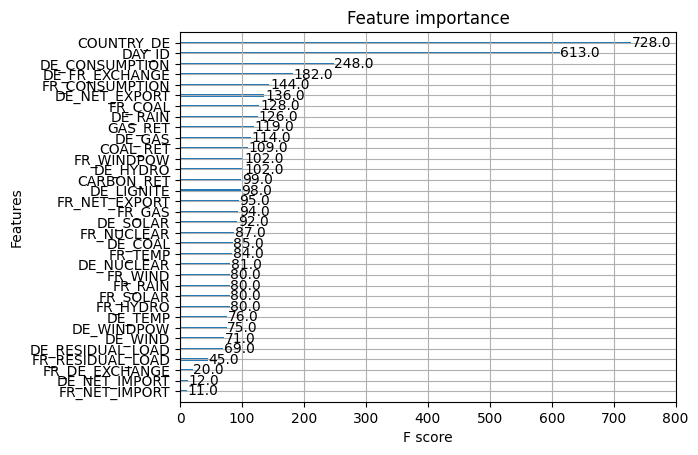

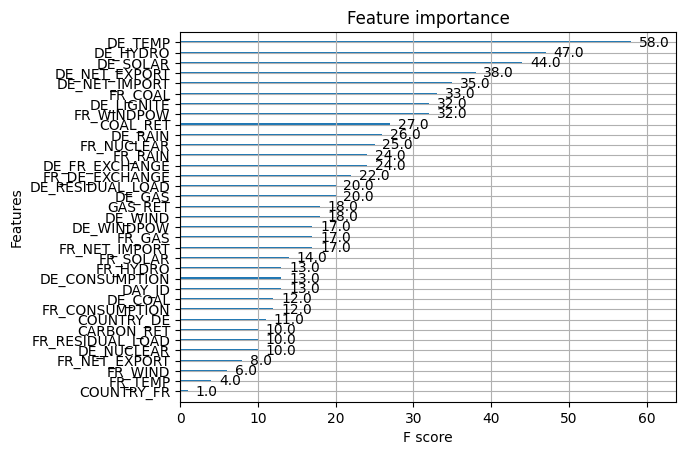

In [400]:
# Plot feature importance
plot_importance(xgb)
plot_importance(cv_xgb)

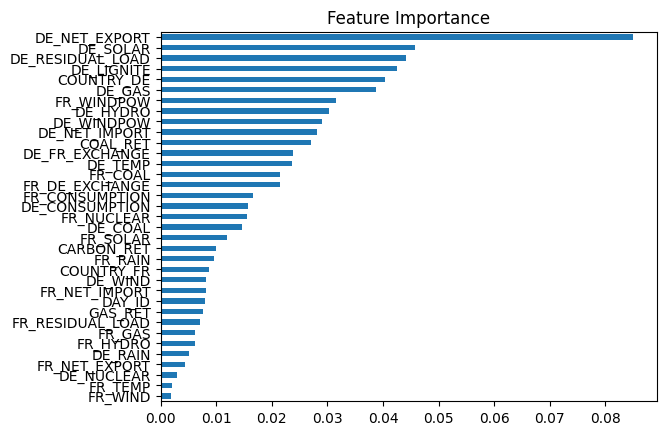

In [401]:
# Perform permutation importance
results = permutation_importance(
    cv_xgb, X_train, y_train, n_repeats=10, random_state=42)

# Get importance scores
importance_scores = results.importances_mean

# Organize and plot the importance scores
importances = pd.Series(importance_scores, index=X_train.columns)
importances = importances.sort_values()

importances.plot(kind='barh')
plt.title('Feature Importance')
plt.show()

# Target Predictions that work better than mine

In [402]:
cross_validated_model = cross_validated_model.sort_values(by='ID')
cross_validated_model.head()

,ID,TARGET
489,1,0.013233
296,6,-0.089530
625,7,-0.186861
532,11,0.219898
430,16,0.080405


In [403]:
full_model = full_model.sort_values(by='ID')
full_model.head()

,ID,TARGET
489,1,0.049958
296,6,0.033146
625,7,0.003718
532,11,0.467708
430,16,0.677177


Text(0.5, 1.0, 'Plot of Target Variable Training Set')

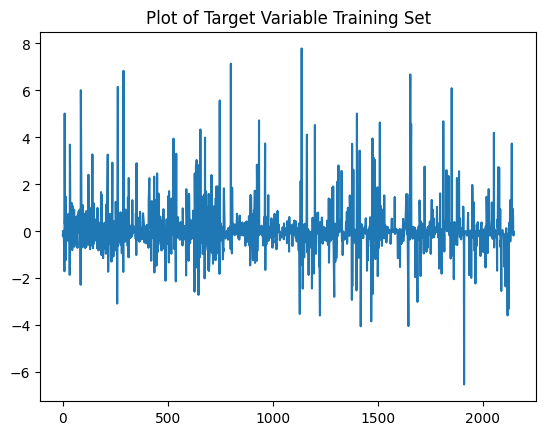

In [404]:
y = y.sort_index()
plt.plot(y['TARGET'])
plt.title('Plot of Target Variable Training Set')

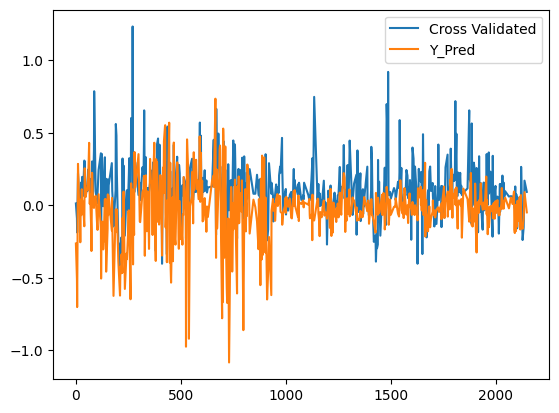

In [405]:
#plt.plot(full_model['ID'], full_model['TARGET'], label='Full Model')

y_pred = pd.read_csv('src/y_pred.csv')
y_pred = y_pred.sort_values(by='ID')

plt.plot(cross_validated_model['ID'], cross_validated_model['TARGET'], label='Cross Validated')
plt.plot(y_pred['ID'], y_pred['TARGET'], label='Y_Pred')
plt.legend()

In [406]:
metric_train(cross_validated_model['TARGET'], y_pred['TARGET'])

0.4443811414430909

In [407]:
prev_pred = pd.read_csv('src/xgb_predictions.csv')
prev_pred = prev_pred.sort_values(by='ID')
metric_train(prev_pred['TARGET'], y_pred['TARGET'])

0.3163720976424004